In [1]:
pip install yfinance

**Import Libraries**

In [3]:
# Importing all the necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping



**Download Tesla Data**

/tmp/ipython-input-3836622023.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2010-01-01", end="2020-01-01")
[*********************100%***********************]  1 of 1 completed


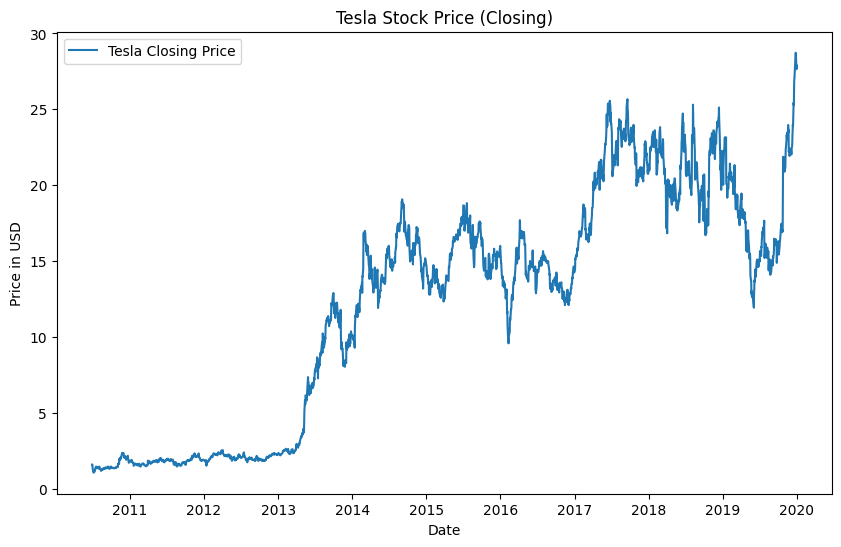

In [4]:
ticker = "TSLA"
data = yf.download(ticker, start="2010-01-01", end="2020-01-01")

plt.figure(figsize=(10,6))
plt.plot(data['Close'], label='Tesla Closing Price')
plt.title('Tesla Stock Price (Closing)')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.show()


**Preprocessing with Multiple Features**

In [5]:
# Use multiple features
data = data[['Open','High','Low','Close','Volume']]

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

# Create sequences: 60 days input → next day Close price
X, y = [], []
time_steps = 60
for i in range(time_steps, len(scaled_data)):
    X.append(scaled_data[i-time_steps:i])   # 60 days × 5 features
    y.append(scaled_data[i, 3])             # Target = Close (index 3)

X = np.array(X)
y = np.array(y)

print("Shape of X:", X.shape)   # (samples, 60, 5)
print("Shape of y:", y.shape)


Shape of X: (2334, 60, 5)
Shape of y: (2334,)


**Train-Test Split**

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)


X_train: (1867, 60, 5)
X_test: (467, 60, 5)


**Build the LSTM Model**

In [7]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output = next day's Close price

model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Train the Model**

In [8]:
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0235 - mae: 0.0937 - val_loss: 0.0030 - val_mae: 0.0412
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0020 - mae: 0.0294 - val_loss: 0.0029 - val_mae: 0.0409
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0019 - mae: 0.0292 - val_loss: 0.0028 - val_mae: 0.0402
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0018 - mae: 0.0284 - val_loss: 0.0036 - val_mae: 0.0487
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015 - mae: 0.0262 - val_loss: 0.0023 - val_mae: 0.0365
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0016 - mae: 0.0270 - val_loss: 0.0022 - val_mae: 0.0359
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0014 - mae: 0.0251 - val_loss: 0.0041 - val_mae: 0.0514
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015 - mae: 0.0261 - val_loss: 0.0023 - val_mae: 0.0363
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.001

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Root Mean Squared Error (RMSE): 0.83


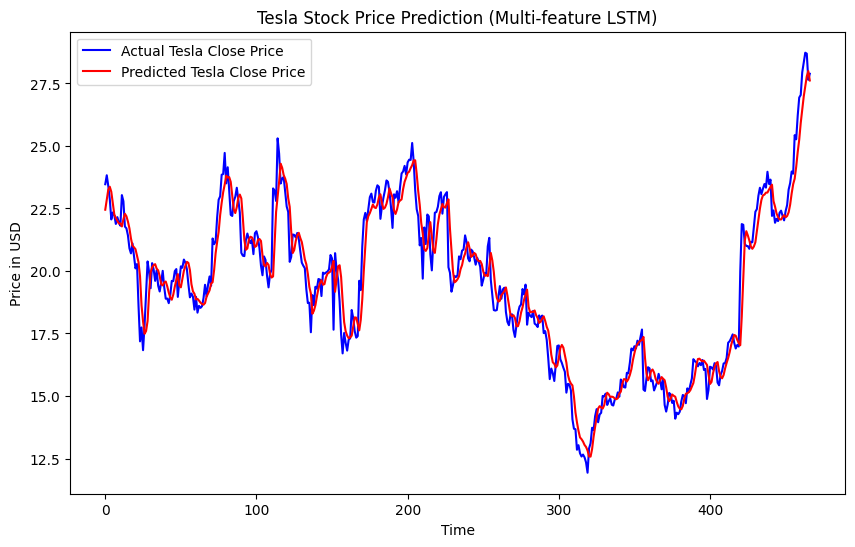

In [9]:
# Make Predictions
predictions = model.predict(X_test)

# Inverse transform only Close column
close_scaler = MinMaxScaler(feature_range=(0,1))
close_scaler.min_, close_scaler.scale_ = scaler.min_[3], scaler.scale_[3]

predictions = close_scaler.inverse_transform(predictions)
y_test_rescaled = close_scaler.inverse_transform(y_test.reshape(-1,1))

# RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Plot results
plt.figure(figsize=(10,6))
plt.plot(y_test_rescaled, color="blue", label="Actual Tesla Close Price")
plt.plot(predictions, color="red", label="Predicted Tesla Close Price")
plt.title("Tesla Stock Price Prediction (Multi-feature LSTM)")
plt.xlabel("Time")
plt.ylabel("Price in USD")
plt.legend()
plt.show()
